<h1><strong><u>K-Nearest Neighbors Model Selection</u></strong></h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, validation_curve
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, CategoricalNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

<h2><u>Data Loading</u></h2>

In [2]:
df = pd.DataFrame(columns=["title", "target"])

In [3]:
# Formatting text files
titles = []
targets = []
file_path_dict = {'clickbait': './clickbait_data.txt', 'non clickbait': './non_clickbait_data.txt'}
for key, value in file_path_dict.items():
    with open(value, 'r') as file:
        for line_number, line in enumerate(file):
            line = line.strip()
            if line != "":
                titles.append(line)
                targets.append(key)
data_dict = {"title": titles, "target": targets}
df = pd.DataFrame(data_dict)


In [4]:
data = df.sample(frac=1).reset_index(drop=True)
display(data)

,title,target
0,What Percent KatyCat Are You,clickbait
1,Rwandan army officer sentenced to 25 years for...,non clickbait
2,17 Times Kourtney Kardashian Shut Down Her Own...,clickbait
3,Canada's Conservatives launch new ad campaign,non clickbait
4,17 Makeup Facts That Show Humans Will Do Anyth...,clickbait
...,...,...
31995,"Andrew Garfield Has Transformed From One ""Harr...",clickbait
31996,Work on Lehman Brothers’ rescue to continue ov...,non clickbait
31997,13 Beautifully Honest Valentine's Cards For Pe...,clickbait
31998,17 Awkward Moments When You're A Jew On Christmas,clickbait


In [5]:
X = data["title"]
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(25600,)

(6400,)

(25600,)

(6400,)

In [6]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

<h2><strong><u>KNN Model Selection</u></strong></h2>

<h3><u>Validation Curves</u></h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ................................clf__n_neighbors=11; total time=  14.3s
[CV] END ................................clf__n_neighbors=71; total time=  16.4s
[CV] END .................................clf__n_neighbors=1; total time=  15.5s
[CV] END ................................clf__n_neighbors=41; total time=  14.4s
[CV] END ................................clf__n_neighbors=81; total time=   6.5s
[CV] END ................................clf__n_neighbors=91; total time=   6.2s
[CV] END ...............................clf__n_neighbors=101; total time=   9.2s
[CV] END ................................clf__n_neighbors=51; total time=  16.3s
[CV] END ................................clf__n_neighbors=61; total time=  16.4s
[CV] END ................................clf__n_neighbors=21; total time=  14.4s
[CV] END ................................clf__n_neighbors=31; total time=  14.4s
[CV] END ...............................clf__n_neighbors=121; total time=   4.4s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:  5.1min remaining:  5.1min


[CV] END ................................clf__n_neighbors=81; total time=   6.2s
[CV] END ................................clf__n_neighbors=91; total time=   9.5s
[CV] END ...............................clf__n_neighbors=121; total time=  12.8s
[CV] END ...............................clf__n_neighbors=131; total time=  12.6s
[CV] END ...............................clf__n_neighbors=181; total time=   7.5s
[CV] END .................................clf__n_neighbors=1; total time=   8.0s
[CV] END ...............................clf__n_neighbors=191; total time=  10.8s
[CV] END ...............................clf__n_neighbors=161; total time=  11.3s
[CV] END ...............................clf__n_neighbors=171; total time=   8.6s
[CV] END ...............................clf__n_neighbors=151; total time=  11.7s
[CV] END ................................clf__n_neighbors=11; total time=   9.2s
[CV] END ...............................clf__n_neighbors=141; total time=  11.7s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.5min finished


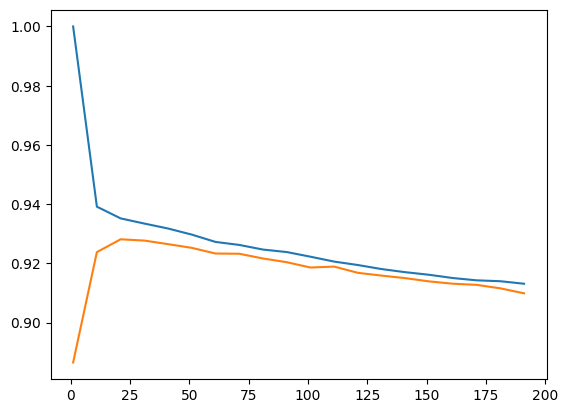

In [9]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", KNeighborsClassifier())
    ]
)
neighbors = list(range(1, 201, 10))
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__n_neighbors",
                                                   param_range=neighbors,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(neighbors, train_scores_mean)
plt.plot(neighbors, validation_scores_mean)

<h3><u>Conclusion From 'Neighbor Count' Validation Curve</u></h3>
I chose to valid for a wide range of neighbors so that I could see the overall test/validation score trend with the increase of neighbors. It is pretty clear to see that 25 is the best neighbor count but for the CV test, I'll use a range from 20-30.

<h3><u>Cross Validation Testing</u></h3>

In [10]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", KNeighborsClassifier())
    ]
)
param_grid = {
    "clf__n_neighbors": [23, 25, 27, 29],
}

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
model.fit(X_train, y_train)
knn_classifier = model.best_estimator_
model.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...............clf__n_neighbors=23;, score=0.929 total time=  13.9s
[CV 1/5] END ...............clf__n_neighbors=25;, score=0.929 total time=  14.0s
[CV 3/5] END ...............clf__n_neighbors=25;, score=0.921 total time=  14.3s
[CV 4/5] END ...............clf__n_neighbors=23;, score=0.932 total time=  14.3s
[CV 2/5] END ...............clf__n_neighbors=23;, score=0.926 total time=  14.4s
[CV 3/5] END ...............clf__n_neighbors=23;, score=0.917 total time=  16.3s
[CV 5/5] END ...............clf__n_neighbors=23;, score=0.931 total time=  16.3s
[CV 2/5] END ...............clf__n_neighbors=25;, score=0.925 total time=  16.3s
[CV 4/5] END ...............clf__n_neighbors=25;, score=0.930 total time=   5.6s
[CV 5/5] END ...............clf__n_neighbors=25;, score=0.931 total time=   8.4s
[CV 3/5] END ...............clf__n_neighbors=27;, score=0.921 total time=   8.8s
[CV 2/5] END ...............clf__n_neighbors=27;,

{'clf__n_neighbors': 29}

<h4><u>K-Nearest Neighbors Training Metrics</u></h4>

In [11]:
knn_training_values = cross_val_score(knn_classifier, X_train, y_train, scoring='accuracy', cv=5)
print(f"Cross-validation Accuracy training scores: ", knn_training_values)
np_knn_training_values = np.array(knn_training_values)
average = np.mean(np_knn_training_values)
stDev = np.std(np_knn_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.93144531 0.92734375 0.92011719 0.93164062 0.93007812]
0.93  +/-  0.0043 



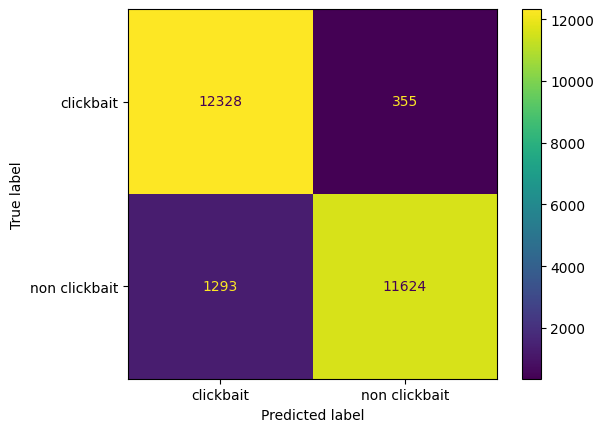

In [12]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_classifier, X_train, y_train)

<h4><u>K-Nearest Neighbors Learning Curves</u></h4>

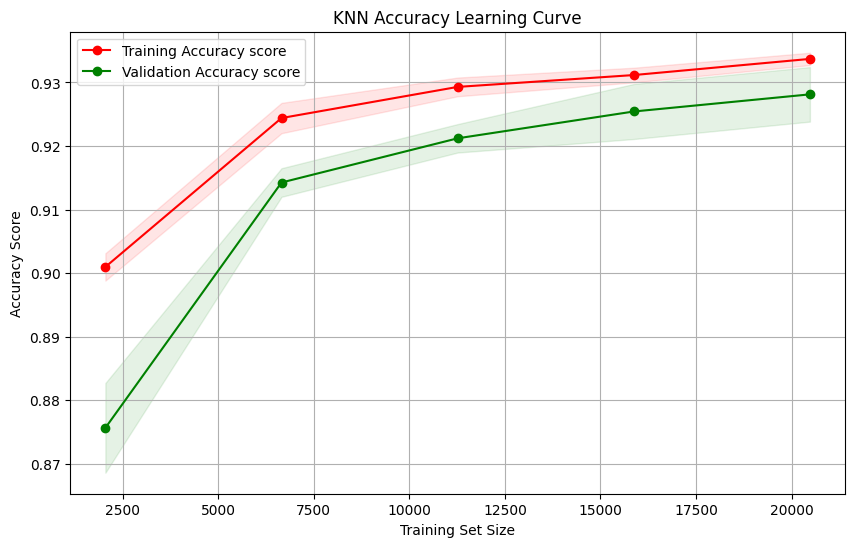

In [13]:
knn_train_sizes, knn_train_scores, knn_validation_scores = learning_curve(
    knn_classifier,
    X_train,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
knn_train_scores_mean = np.mean(knn_train_scores, axis=1)
knn_train_scores_std = np.std(knn_train_scores, axis=1)
knn_validation_scores_mean = np.mean(knn_validation_scores, axis=1)
knn_validation_scores_std = np.std(knn_validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("KNN Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.grid()

plt.fill_between(knn_train_sizes, knn_train_scores_mean - knn_train_scores_std,
                knn_train_scores_mean + knn_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(knn_train_sizes, knn_validation_scores_mean - knn_validation_scores_std,
                knn_validation_scores_mean + knn_validation_scores_std, alpha=0.1,
                color="g")
plt.plot(knn_train_sizes, knn_train_scores_mean, 'o-', color="r",
            label="Training Accuracy score")
plt.plot(knn_train_sizes, knn_validation_scores_mean, 'o-', color="g",
            label="Validation Accuracy score")

plt.legend(loc="best")
plt.show()

<h4><u>K-Nearest Neighbors Testing Metrics</u></h4>

In [19]:
knn_test_predictions = knn_classifier.predict(X_test)

knn_test_accuracy = accuracy_score(y_test, knn_test_predictions)
print("K-Nearest Neighbors Test Accuracy: {:.2f}%".format(knn_test_accuracy * 100))

K-Nearest Neighbors Test Accuracy: 93.22%


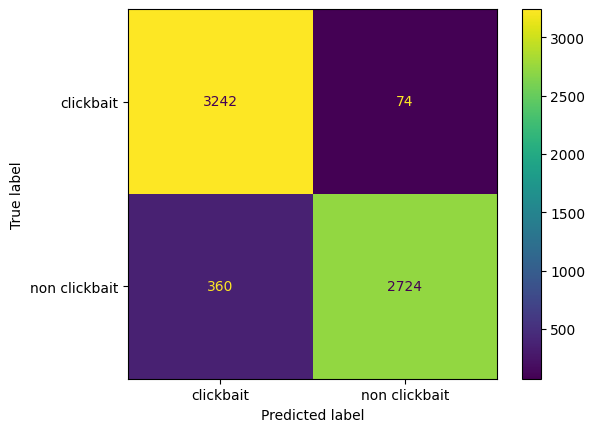

In [20]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, knn_test_predictions)